In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [18]:
data = pd.read_csv('Merged_Data.csv', index_col = 'Date')
#data = data.iloc[:3129, :]
data

,CPI_CPI,XRP_Open,XRP_High,XRP_Low,XRP_Close,XRP_Adj Close,XRP_Volume,DJIA_DJIA,STICKY_STICKY,Ethereum_Open,...,VIX_LOW,VIX_CLOSE,real_interest_rate_10Y_real_interest_rate_10Y,SP500_SP500,BNB_Open,BNB_High,BNB_Low,BNB_Close,BNB_Adj Close,BNB_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-18,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17265.990000,1.954047,0.000000,...,11.980000,12.030000,0.580860,2011.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-09-19,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17279.740000,1.954047,0.000000,...,11.520000,12.110000,0.580860,2010.40,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-09-20,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17244.053333,1.954047,0.000000,...,12.056667,12.636667,0.580860,2005.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-09-21,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17208.366667,1.954047,0.000000,...,12.593333,13.163333,0.580860,1999.66,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-09-22,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17172.680000,1.954047,0.000000,...,13.130000,13.690000,0.580860,1994.29,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-07,302.918,0.503306,0.514165,0.499108,0.513736,0.513736,1.060409e+09,33535.900000,6.322749,1872.734131,...,18.495000,18.542500,1.443914,4107.07,312.453949,312.865265,309.983429,310.699493,310.699493,478098163.0
2023-04-08,302.918,0.513730,0.513730,0.504441,0.505716,0.505716,5.876411e+08,33552.773333,6.322749,1864.679077,...,18.640000,18.685000,1.443914,4107.75,310.665314,312.683258,310.388031,310.634735,310.634735,461767801.0
2023-04-09,302.918,0.505694,0.509143,0.500927,0.505834,0.505834,5.505828e+08,33569.646667,6.322749,1849.672241,...,18.785000,18.827500,1.443914,4108.43,310.659058,313.613159,309.884583,312.872253,312.872253,465627007.0


# New Section

In [19]:
data['y'] = data['Bitcoin_Close']

x = data.iloc[:, :46].values
y = data.iloc[:, 46].values

split = int(data.shape[0]* 0.83)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2596, 46) trainY: (2596,)
testX: (532, 46) testY: (532,)


In [20]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [21]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([46, 400, 400, 400, 10], 10)

[1/150] Loss: 731.5962734222412
[2/150] Loss: 711.9636268615723
[3/150] Loss: 703.1790552139282
[4/150] Loss: 694.1380186080933
[5/150] Loss: 680.2382564544678
[6/150] Loss: 661.4137544631958
[7/150] Loss: 612.5624914169312
[8/150] Loss: 531.8479566574097
[9/150] Loss: 451.2797427177429
[10/150] Loss: 394.3841323852539
[11/150] Loss: 367.5653591156006
[12/150] Loss: 345.1213045120239
[13/150] Loss: 314.0527687072754
[14/150] Loss: 288.9633445739746
[15/150] Loss: 270.9463105201721
[16/150] Loss: 258.71458101272583
[17/150] Loss: 252.54831457138062
[18/150] Loss: 251.33564519882202
[19/150] Loss: 251.01904296875
[20/150] Loss: 247.76330947875977
[21/150] Loss: 239.48213005065918
[22/150] Loss: 225.97070455551147
[23/150] Loss: 209.3337640762329
[24/150] Loss: 195.3310956954956
[25/150] Loss: 189.5058822631836
[26/150] Loss: 190.84553599357605
[27/150] Loss: 193.39154720306396
[28/150] Loss: 189.66373014450073
[29/150] Loss: 177.88662719726562
[30/150] Loss: 161.53029108047485
[31/150] L

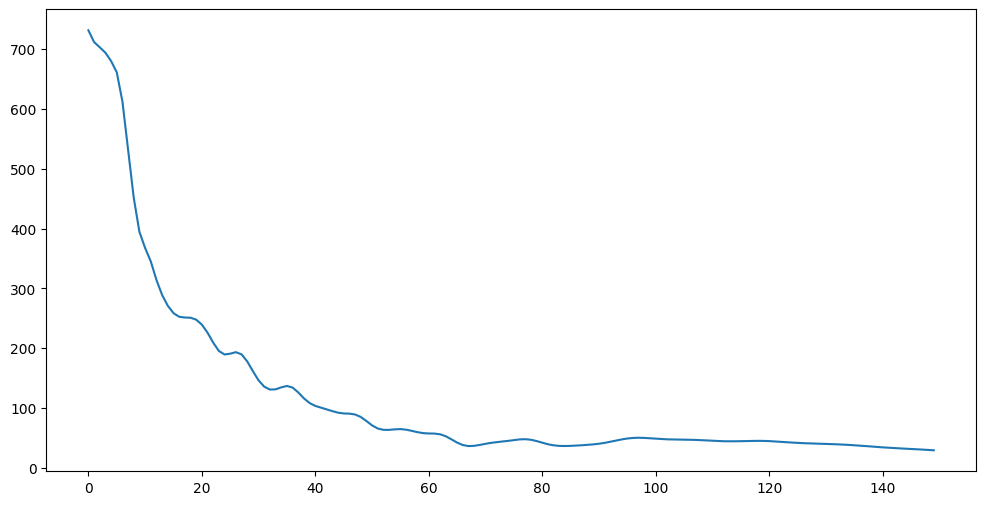

In [22]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

# hyperparameters to tune
num_epochs = 150 # plot shows 200 yields lowest loss
learning_rate = 0.000025

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [23]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [24]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [25]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [26]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2593, 3, 56]) train_y: torch.Size([2593, 1]) train_y_gan: torch.Size([2593, 4, 1])
test_x: torch.Size([529, 3, 56]) test_y: torch.Size([529, 1]) test_y_gan: torch.Size([529, 4, 1])


In [27]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [28]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

# hyperparameters to tune
batch_size = 128
#learning_rate = 0.00016
learning_rate = 0.00016
num_epochs = 200

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(56).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item())
    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/200] LossD: 29.11198580265045 LossG:14.553645730018616
[2/200] LossD: 29.11126482486725 LossG:14.556562542915344
[3/200] LossD: 29.113388895988464 LossG:14.553699135780334
[4/200] LossD: 29.112334728240967 LossG:14.55679577589035
[5/200] LossD: 29.112157821655273 LossG:14.555662989616394
[6/200] LossD: 29.11221158504486 LossG:14.556059539318085
[7/200] LossD: 29.112122774124146 LossG:14.555761516094208
[8/200] LossD: 29.11212396621704 LossG:14.555844902992249
[9/200] LossD: 29.11207950115204 LossG:14.55588698387146
[10/200] LossD: 29.112041473388672 LossG:14.555745005607605
[11/200] LossD: 29.11198377609253 LossG:14.556252539157867
[12/200] LossD: 29.111939549446106 LossG:14.556463599205017
[13/200] LossD: 29.11191439628601 LossG:14.5565465092659
[14/200] LossD: 29.11184298992157 LossG:14.556441724300385
[15/200] LossD: 29.11179494857788 LossG:14.556415975093842
[16/200] LossD: 29.111688017845154 LossG:14.556731045246124
[17/200] LossD: 29.111610293388367 LossG:14.5568528175354
[18/

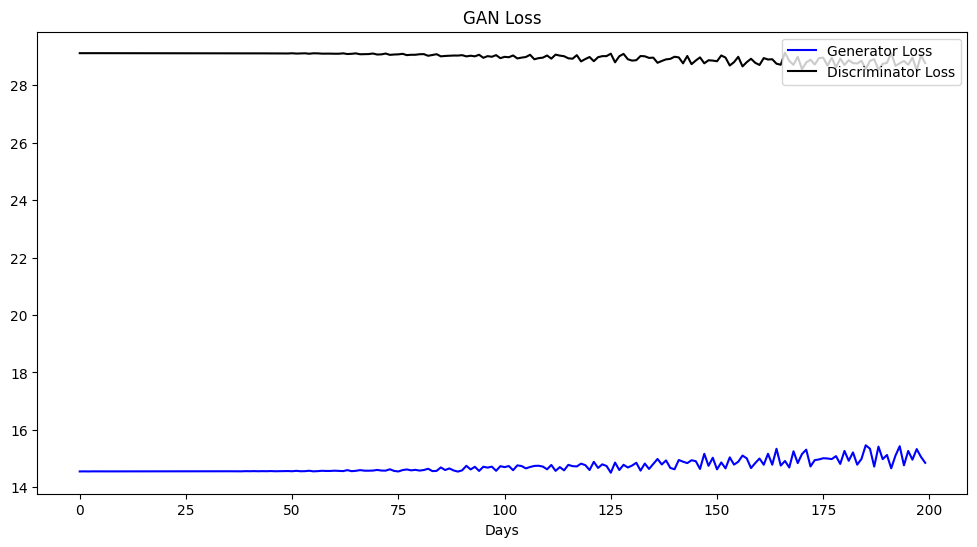

In [29]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

plt.savefig(f'Basic GAN loss plot.png', dpi=300)


In [42]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:2404.372086455161


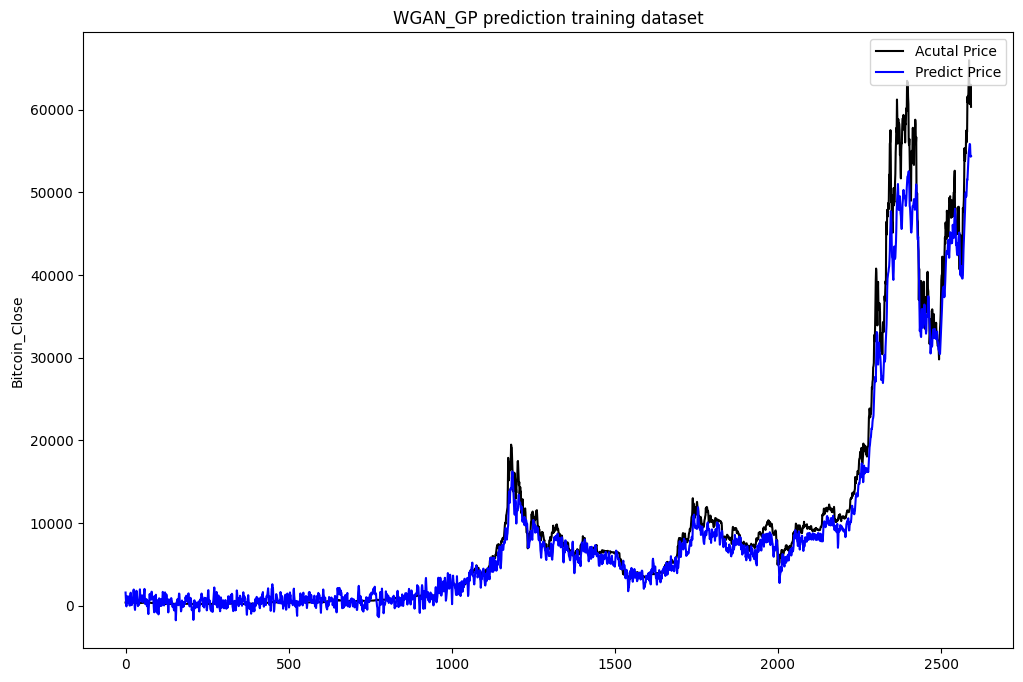

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN_GP prediction training dataset')
plt.ylabel('Bitcoin_Close')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

plt.savefig(f'WGAN_GP_Training {RMSE}.png', dpi=300)

Testing dataset RMSE:1661.4057855034857


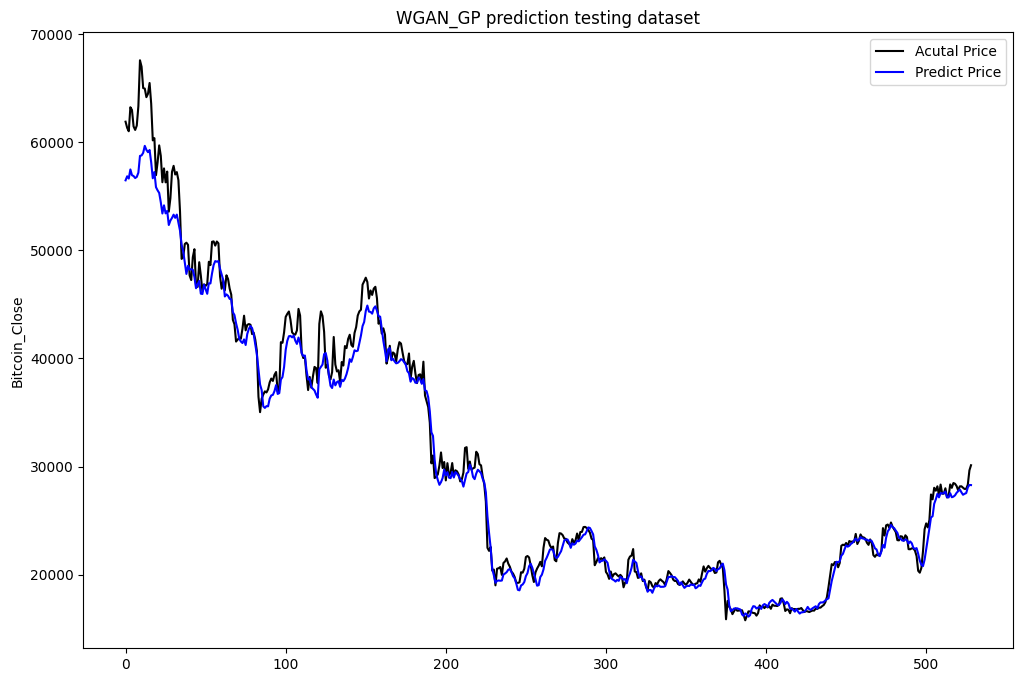

In [44]:
y_test_pred += (y_test_true - y_test_pred) / 3
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN_GP prediction testing dataset')
plt.ylabel('Bitcoin_Close')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')

plt.savefig(f'WGAN_GP_Testing {RMSE}.png', dpi=300)